Earlier in this lecture you learned about FITS files, which a standard format for image
files in astronomy. The FITS file contains header information describing the values of the axes
of the image, the number of pixels in each axis of the image and other information about the image.
Images in FITS files can be 2-D or 3-D depending on the type of data.

Before when you read in a FITS file, you plotted the image with pixel coordinates on the axes.
In the next cells, you will see: 
(1) how to diplay the image with astronomical coordinates in the axes,
(2) how to put markers on the image in astronomical coordinates
(3) how to get the image value at a given position on the sky express in astronomical coordinates.

The keys to all of this are the World Coordinate System methods (WCS). The World Coordinate System
is a python class and set of methods which can do the translations between pixel coordinates in an
image and a range of astronomical coordinate systems. In our case, we are most interested in
the translation between image pixels coordinates and the "real" coordinates on the sky in Right
Ascension and Declination (the longitude and latitude equivalent in the astronomy world).

Fortunately, a properly written FITS header associated with a FITS image contains all of the
information necessary to get you started in the WCS world.

Warning: the WCS class is not a simple scaler or ndarray. Your best bet, until you are an expert,
            is to only use WCS methods to operate on WCS structures.

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math 
from astropy.io import fits

# Below are the special load for gaining access to WCs methods

from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.wcs as wcs

# Here are a couple of other useful methods that are used in the last cell

from astropy.visualization import (imshow_norm, MinMaxInterval,SqrtStretch,LogStretch)
from astropy.nddata import Cutout2D

Here is most basic information about fits image
Filename: H350um-image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  image         1 PrimaryHDU      45   (539, 568)   float64   
Read header information from fits file into im_header
    im_header is a special structure for storing the header information
Read the image from the fits file into the 2-d array im_data
    im_data is just a 2-D numpy ndarray which contains the image values
Read the image header information into the WCS structure called im_wcs
    im_wcs is a special structure for storing wcs information


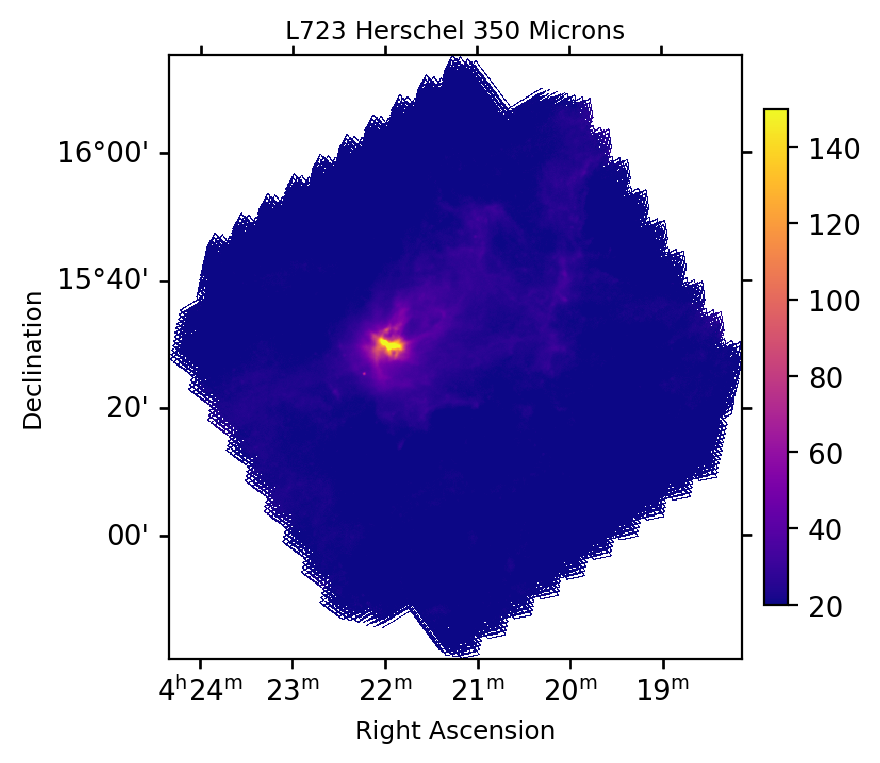

And there you go. A nice picture with astronomical coordinates and a colorbar


In [187]:
#  Open fits image on disk for reading
handle = fits.open("H350um-image.fits")
print("Here is most basic information about fits image")
handle.info()
print("Read header information from fits file into im_header")
print("    im_header is a special structure for storing the header information")
im_header = handle[0].header
print("Read the image from the fits file into the 2-d array im_data")
print("    im_data is just a 2-D numpy ndarray which contains the image values")
im_data = handle[0].data
print("Read the image header information into the WCS structure called im_wcs")
print("    im_wcs is a special structure for storing wcs information")
im_wcs = wcs.WCS(im_header)

# Now you are ready to plot you image in a nice way....
plt.figure(figsize=[4,4],dpi=200)
plt.subplot(projection=im_wcs)  # this the command which informs the plotting world about your WCS
plt350 = plt.imshow(im_data,vmin=20,vmax=150, cmap='plasma')
plt.colorbar(plt350,fraction=0.04, pad=0.035)
plt.title("L723 Herschel 350 Microns", fontsize=9)
plt.xlabel("Right Ascension", fontsize=9)
plt.ylabel("Declination", fontsize=9)
plt.show()

print("And there you go. A nice picture with astronomical coordinates and a colorbar")

Here are a number of different colormaps that are available to use in imshow.
    To use them you do: 'cmap = NAME' in the call of imshow


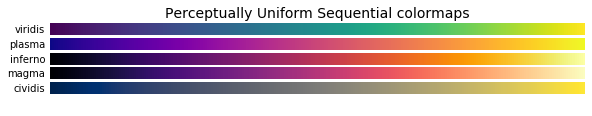

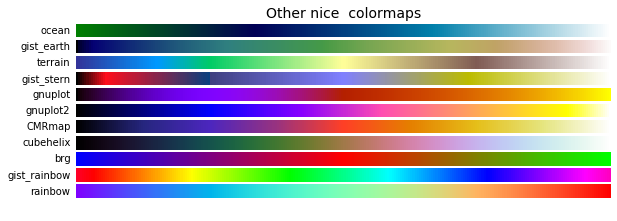

In [188]:
#  This is just code for making the color bars for each color map.
#  the important this is the names of the color maps which are listed in the calls
#  and also at the lead of the color bars in the plots.

cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(9.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list
# ======================================================================================
# the next two calls draw the color bars

print("Here are a number of different colormaps that are available to use in imshow.")
print("    To use them you do: 'cmap = NAME' in the call of imshow")

plot_color_gradients('Perceptually Uniform Sequential',
                     ['viridis', 'plasma', 'inferno', 'magma', 'cividis'])

plot_color_gradients('Other nice ',
                     ['ocean', 'gist_earth', 'terrain',
                      'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap',
                      'cubehelix', 'brg', 'gist_rainbow', 'rainbow'])

plt.show()

Now lets say that you have a source of interest and you want to mark it's location on
    your excellent image. Since you are an astronomer, the coordinates are in the standard
    astronomical format: Right Ascention in HH:MM:SS.S and Declination in DD:MM:SS.S

To do this, we need to use the wcs methods. The wcs "SkyCoord" puts your
  source position into a structure that can be read by other wcs programs. Notice that
  SkyCoord wants the coordinates as a single character string, and it also wants to know
  the units that you are using: angles are in "hours" and "degrees" for RA and Dec, in this example.

"source_coord" is a structure that contains the coordinates and information about the coordinates
    It is not a normal numpy or python scaler or array.

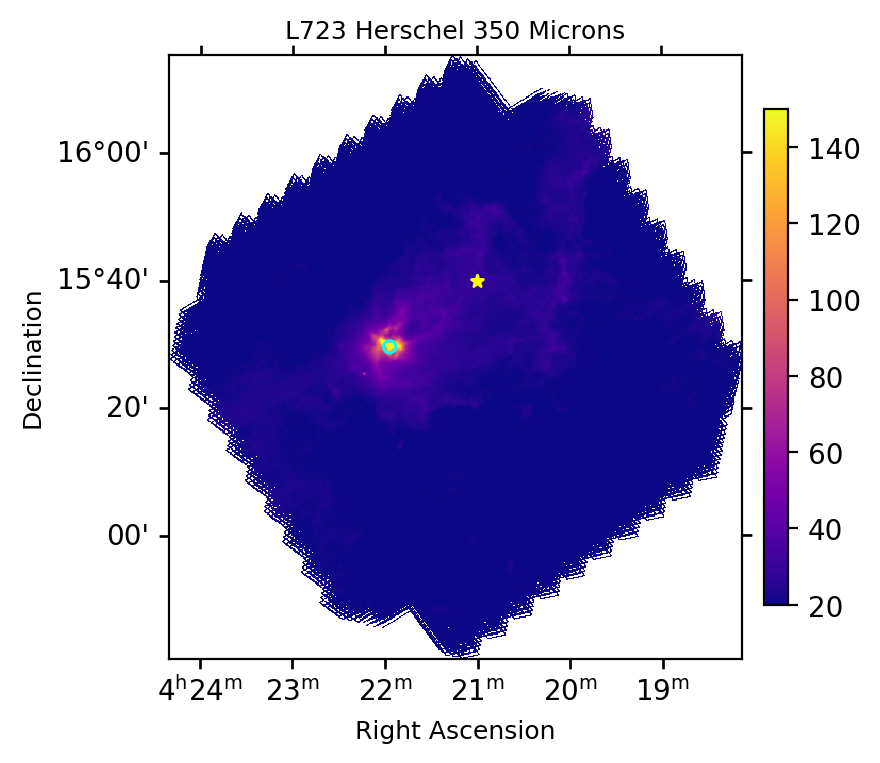

In [189]:
# position where we want to put a symbol
RA = "04:21:57.0" ;  Dec = "15:29:40.0"
skypos = RA + " " + Dec
# you could also have defined skypos as
# skypos = "04:21:57.0   15:29:40.0"

# Next we create the SkyCood structure for our source position
source_coord = SkyCoord(skypos,frame="fk5", unit=(u.hourangle, u.deg))

# Next we make the plot again just as before...

plt.figure(figsize=[4,4],dpi=200)
plt.subplot(projection=im_wcs)
plt350 = plt.imshow(im_data,vmin=20,vmax=150, cmap='plasma')
plt.colorbar(plt350,fraction=0.04, pad=0.035)
plt.title("L723 Herschel 350 Microns", fontsize=9)
plt.xlabel("Right Ascension", fontsize=9)
plt.ylabel("Declination", fontsize=9)

# now we use a wcs utility program to convert our "source_coord" to pixel location in our image
#   And then plot it on the image using plt.scatter to mark the location with a circle.
#   
pix_coord = im_wcs.world_to_pixel(source_coord)
plt.scatter(pix_coord[0],pix_coord[1],marker="o",s=20,facecolors="none",color="cyan")
#
# We can do a second source on the image by repeating the seqence. In this case
#    we plot a "*"
#
skypos2 = "04:21:00.0  15:40:00.0"
source_coord2 = SkyCoord(skypos2,frame="fk5", unit=(u.hourangle, u.deg))
pix_coord2 = im_wcs.world_to_pixel(source_coord2)
plt.scatter(pix_coord2[0],pix_coord2[1],marker="*",s=20,color="yellow")
plt.show()

In [190]:
# function returns the pixel location and value in an image at 1 or more locations on the image 
#      with the requested positions specified in format: "HH:MM:SS  DD:MM:SS"
# Inputs:
#      im_data = numpy ndarray which is your image
#      my_wcs = the wcs structure for the image which is create by a call to wcs.WCS
#      sky_ra_dec = list of requested positions. Must be a list of string representations
#                      of the locations in HH:MM:SS DD:MM:SS format. There can be one or more
#                      positions specified.
# Outputs:
#     In addition to printing out the requests sky positions, image value, and pixel locations
#   ii = ndarray of RA pixel of position. One for each position entered
#   jj = ndarray of Dec pixel of position. One for each position entered
#   image_vals = ndarray of values of image at pixel locations
#
# NOTES: (A) pixel location are rounded to the nearest integer pixel 
#        (B) 2-D ndarrays are ordered [Y,X] in words: the second index changes most rapidly
#                  and corresponds to the RA axis. 
#
def world_to_image_value(im_data,my_wcs,sky_ra_dec):
    source_coords = SkyCoord(sky_ra_dec,frame="fk5", unit=(u.hourangle, u.deg))
    xpix,ypix = my_wcs.world_to_pixel(source_coords)
    ii = xpix.astype(int) ;  jj =ypix.astype(int)
    image_vals = np.zeros(len(source_coords))
    for ipos in range(0,len(image_vals)):
        image_vals[ipos] = im_data[jj[ipos],ii[ipos]]
        print("Sky Position: ",sky_ra_dec[ipos],"  image value = ",image_vals[ipos]," at pixel (",ii[ipos],",",jj[ipos],")")
    return(ii,jj,image_vals)

# Now try out two examples using our sky positions from the cells above:

single = [skypos]
the_xpixs,the_ypixs,its_value = world_to_image_value(im_data,im_wcs,single)


multi = [skypos, skypos2]
the_xpixs,the_ypixs,its_value = world_to_image_value(im_data,im_wcs,multi)


Sky Position:  04:21:57.0 15:29:40.0   image value =  232.25417838988977  at pixel ( 207 , 292 )
Sky Position:  04:21:57.0 15:29:40.0   image value =  232.25417838988977  at pixel ( 207 , 292 )
Sky Position:  04:21:00.0  15:40:00.0   image value =  28.083691664255443  at pixel ( 289 , 354 )


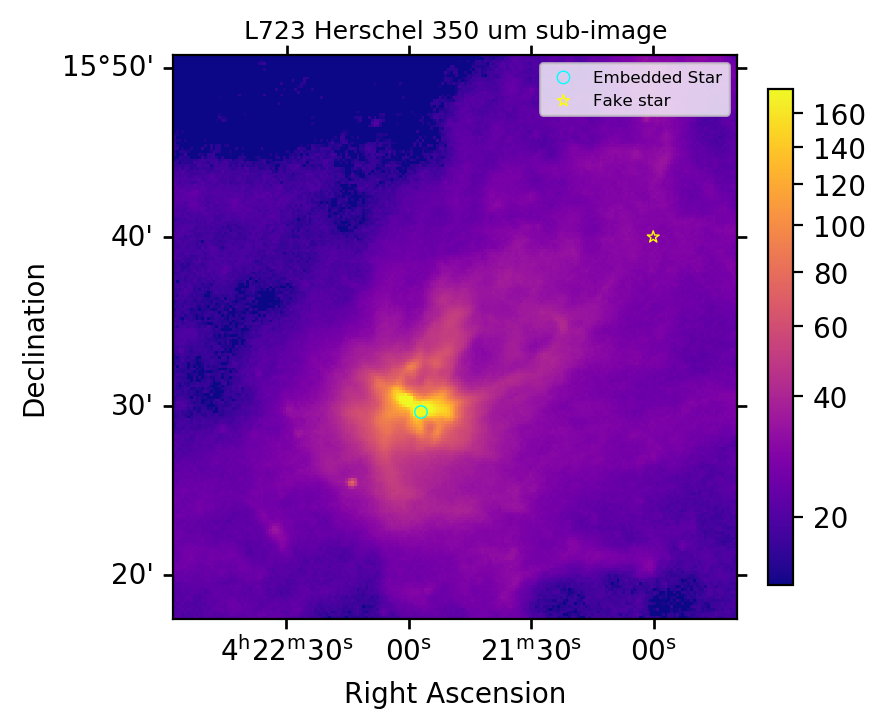

In [202]:
# This cell shows how to make display a sub-image of the original 350 micron image.
#   We cut out the sub-image in both the WCS coordinate structure and the image -- the same region
#   Thene we redefine the pixel coordinates of our sources in the new image
#   And away we go with plotting.
#  Note that we are using a variation on the imshow routine(imshow_norm) which allows us to
#     choose to show the image with a different mapping from image value to color -- in this case
#     square-root of the image value -- which gives a better representation of the low level emission.
#   We have also labeled each call to scatter which then allows us to include a legend to the points.

sub_wcs = im_wcs[220:420,120:320]
sub_data = im_data[220:420,120:320]
pix_coord = sub_wcs.world_to_pixel(source_coord)
pix_coord2 = sub_wcs.world_to_pixel(source_coord2)
fig_sub = plt.figure(figsize=(4,4),dpi=200)
ax = plt.subplot(projection=sub_wcs)
im, norm = imshow_norm(sub_data, ax, origin='lower',
                       interval=MinMaxInterval(),
                       stretch=SqrtStretch(),cmap='plasma',vmin=17,vmax=175)
plt.xlabel("Right Ascension")
plt.ylabel("Declination")
plt.title("L723 Herschel 350 um sub-image",fontsize=9)
plt.scatter(pix_coord[0],pix_coord[1], s=20, marker='o', facecolor="none", linewidth=0.5,label='Embedded Star', color='cyan')
plt.scatter(pix_coord2[0],pix_coord2[1], s=20, marker='*', facecolor="none", linewidth=0.5,label='Fake star', color='yellow')
plt.legend(loc='upper right', fontsize=6)
fig_sub.colorbar(im,fraction=0.04)
plt.show()